**Problem Statement:**

We have been given a PDE: du/dx=2du/dt+u and boundary condition: u(x,0)=10e^(-5x)

Independent variables: x,t (input)
Dependent variables: u (outputs)
We have to find out u(x,t) for all x in range [0,10] and t in range [0,10]

Our function is f = du/dx - 2du/dt - u

In [1]:
import numpy as np
import torch
import torch.nn as NN
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Model Architecture**

In [2]:
class Net(NN.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.h1 = NN.Linear(2,10)
        self.h2 = NN.Linear(10,10)
        self.h3 = NN.Linear(10,10)
        self.h4 = NN.Linear(10,10)
        self.h5 = NN.Linear(10,5)
        self.output_layer = NN.Linear(5,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # Two arrays of 1 column each -----> One array of 2 columns
        layer1_out = torch.tanh(self.h1(inputs))
        layer2_out = torch.tanh(self.h2(layer1_out))
        layer3_out = torch.tanh(self.h3(layer2_out))
        layer4_out = torch.tanh(self.h4(layer3_out))
        layer5_out = torch.tanh(self.h5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output

In [3]:
net = Net()
net = net.to(device)
loss_fn=NN.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

In [4]:
## PDE as loss function. 
def f(x,t, net):
    u = net(x,t) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our f = du/dx - 2du/dt - u, we need du/dx and du/dt
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_x - 2*u_t - u
    return pde

In [5]:
## Data from Boundary Conditions

# BC tells us that for any x in range[0,2] and time=0, the value of u is given by 6e^(-3x)
# Take say 500 random numbers of x
x_bc = np.random.uniform(low=0.0, high=10.0, size=(500,1))
t_bc = np.zeros((500,1))
# compute u based on BC
u_bc = 10*np.exp(-5*x_bc)

In [ ]:
iterations = 10000
previous_validation_loss = 99999999.0
for epoch in range(iterations):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc, pt_t_bc) # output of u(x,t)
    loss_u = loss_fn(net_bc_out, pt_u_bc)
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=0.0, high=10.0, size=(500,1))
    t_collocation = np.random.uniform(low=0.0, high=10.0, size=(500,1))
    all_zeros = np.zeros((500,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, pt_t_collocation, net) # output of f(x,t)
    loss_f = loss_fn(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = loss_u + loss_f
    
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to : theta_new = theta_old - alpha * derivative of J w.r.t theta

    with torch.autograd.no_grad():
    	print(epoch,"Traning Loss:",loss.data)
    

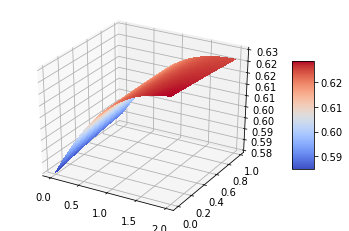

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

x=np.arange(0,2,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
             
             

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()